In [54]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns

#stats
#from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
#from wordcloud import WordCloud ,STOPWORDS
#from PIL import Image
#import matplotlib_venn as venn

In [13]:
path='/Users/fengxiao/Documents/Johns Hopkins MS Data Science/2018 Spring/ML projects/Toxic Comment Classification Challenge/'
train=pd.read_csv(path+'train 2.csv')
test = pd.read_csv(path + 'test 2.csv')

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [32]:
# print test and train data size
print('train row count: {}'.format(train.shape[0]))
print('test row count: {}'.format(test.shape[0]))


train row count: 159571
test row count: 153164


In [36]:
# get rows with no tags 'clean'
tags = train.iloc[:,2:]
tags['none']=(tags.sum(1)==0)

Text(0.5,0,'Type')

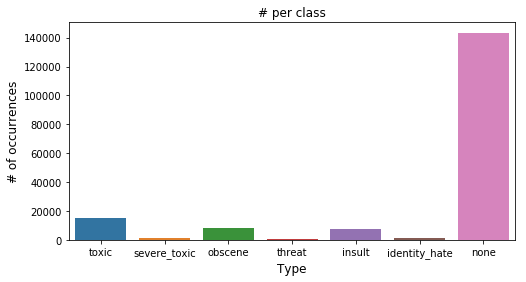

In [66]:
# plot tags barplot
x=tags.sum(0)
plt.figure(figsize=(8,4))
sns.barplot( x=x.index, y=x.values)

plt.title('# per class')
plt.ylabel('# of occurrences', fontsize=12)
plt.xlabel('Type', fontsize=12)

Text(0.5,0,'# of tags')

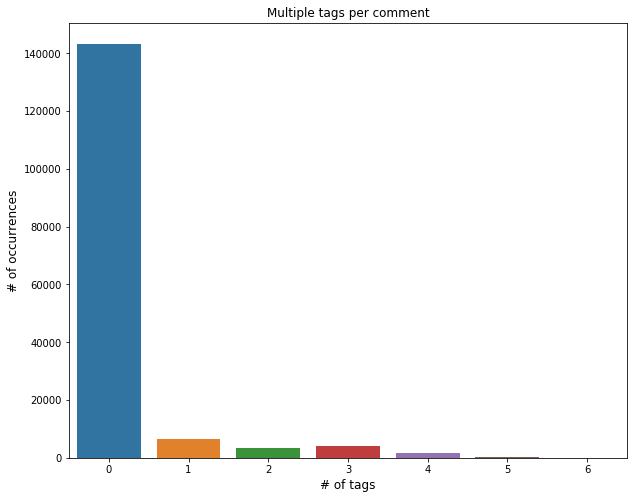

In [65]:
# plot multi tagging
tags_multi=tags.drop('none',axis=1)
x=tags_multi.sum(1).value_counts()
plt.figure(figsize=(10,8))

sns.barplot(x.index, x.values)

plt.title('Multiple tags per comment')
plt.ylabel('# of occurrences', fontsize=12)
plt.xlabel('# of tags', fontsize=12)

In [ ]:
# heat map of tags



In [4]:
train.shape

(159571, 8)

train dataset contains text contant and labels. our goal is to analyze comment_text to predict its label
To start, I followed Jeremy's NB-SVM EDA to have a good baseline 

In [5]:
# len of comment_text varies a lot
lens = train.comment_text.str.len()
lens.min(),lens.std(), lens.max()

(6, 590.72028190489186, 5000)

In [6]:
lens.hist();

In [7]:
# create a list of all labels to predict, create a 'none' label so we can see how many commens have no labels. We  can then summarize the dataset

label_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
none             False
dtype: bool

## Build the model
First, define tokenize

In [9]:
import re,string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [22]:

vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize, min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1, smooth_idf=1, sublinear_tf=1,stop_words='english')
train_term_doc = vec.fit_transform(train['comment_text'])
test_term_doc = vec.transform(test['comment_text'])

In [16]:
train_term_doc[0]

<1x426005 sparse matrix of type '<class 'numpy.float64'>'
	with 100 stored elements in Compressed Sparse Row format>

In [19]:
names = vec.get_feature_names()